In [24]:
import xarray as xr
import os
import oscarplus as op
import matplotlib.pyplot as plt
import plot_helpers as ph
import subplots as splot
from oscarplus.processing.secondary_products import calculate_upwelling_SWT
from matplotlib.colors import LinearSegmentedColormap

# Making figures 1, 2 and 4

## Input parameters for plotting

In [25]:
# OSCAR
date = "20220517"
track = "2"
gmf = "mouche12kp20_rsv20"
# MARS
MARS2DTIME = "2022-05-17T09:30:00.000000000"
MARS3DTIME = "2022-05-17T09:00:00.000000000"
# plotting parameters
MARS_extent = [-5.18, -5.05, 48.368, 48.525]

## Load and process data for single day plots and transects

In [26]:
# load bathymetry
bathymetry_path = op.tools.readers.get_data_dirs()["bathymetry"]
bathymetry = xr.open_mfdataset(
    os.path.join(bathymetry_path, "Iroise_Sea_Bathymetry_EMODnet.nc")
)  # change path to select a different file

# load OSCAR
OSCAR, _ = op.tools.readers.read_OSCAR(date, track, gmf, "L2a MF")
calculate_upwelling_SWT(OSCAR, -bathymetry["elevation"])  # add currentW to L2a_MF
OSCAR = op.tools.utils.cut_NaNs(OSCAR)

# load MARS2D
MARS2D = op.tools.readers.read_MARS2D(
    "MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc", 250
)
MARS2D = MARS2D.sel(time=MARS2DTIME)
MARS2D = op.tools.utils.cut_to_extent(MARS2D, MARS_extent)
op.processing.secondary_products.calculate_secondary_products(MARS2D)
calculate_upwelling_SWT(MARS2D, -bathymetry["elevation"])  # add currentW to MARS2D

#load MARS3D
MARS3D = op.tools.readers.read_MARS3D(
    "MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc", 250
)
MARS3D = MARS3D.sel(time=MARS3DTIME)
MARS3D = op.tools.utils.cut_to_extent(MARS3D, MARS_extent)
op.processing.secondary_products.calculate_secondary_products(MARS3D)


C:\Users\arius\python_modules\oscarplus\tools\utils.py:660: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:660: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:660: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")


In [27]:
# Take transects
current_transect_north, elevation_transect_north = op.tools.utils.transect(
    OSCAR,
    bathymetry,
    iGround=0,
    jCross=59,
    angle=225,
)
current_transect_south, elevation_transect_south = op.tools.utils.transect(
    OSCAR,
    bathymetry,
    iGround=10,
    jCross=19,
    angle=135,
)

## Make figures

In [37]:
# Functions

# Colourmap used for bathymetry on the secondary product plots
Bathymetrycmap = LinearSegmentedColormap.from_list(
    "Bathymetrycmap",
    [
        [0.0, "#777777"],
        [0.5, "#444444"],
        [1.0, "#000000"],
    ],
)


def plot_all_three_on_one(
    DS,
    bathymetry,
    figsize,
    legend_location="upper right",
    xoffset=0,
    yoffset=0,
):
    """Plot the current, divergence and vertical current on the same figure"""
    _, axes, extent = ph.make_axes(
        DS,
        1,
        3,
        figsize=figsize,
        dpi=300,
        title=None,
        xoffset=xoffset,
        yoffset=yoffset,
    )

    depth = -bathymetry["elevation"]

    cmaps = ["YlGn", Bathymetrycmap, Bathymetrycmap]

    # Plot bathymetry
    for ax, cmap in zip(axes, cmaps):
        splot.contours(
            depth,
            ax=ax,
            extent=extent,
            vmin=40,
            vmax=120,
            level_step=20,
            legend_title="Elevation",
            linewidths=0.8,
            legend_location=legend_location,
            cmap=cmap,
        )

    # Plot current
    splot.quiver_with_background(
        DS,
        ax=axes[0],
        selection="Current",
        title="Current",
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    )
    # Plot divergence
    gl2 = splot.single(
        DS["CurrentDivergence"],
        ax=axes[1],
        extent=extent,
        title="Divergence",
        cbar_label="Divergence/f",
        vmax=20,
    )
    # Plot vertical current
    gl3 = splot.single(
        DS["CurrentW"],
        ax=axes[2],
        extent=extent,
        title="Surface Vertical Current",
        cbar_label="Current W [$m/s$]",
        vmax=0.2,
    )

    # Remove left labels from the middle and right plot
    gl2.left_labels = False
    gl3.left_labels = False

    ph.add_letters(axes)
    plt.subplots_adjust(wspace=0.05)

    return axes


def plot_transects(
    current_transects,
    elevation_transects,
    symmetric_velocity=False,
):
    """Plot the transects of the current velocity and the elevation"""

    def make_axes_lim_symmetric(ax):
        """Make the y-axis symmetric around 0"""
        ylim = ax.get_ylim()
        max_lim = max(abs(ylim[0]), abs(ylim[1]))
        ax.set_ylim(-max_lim, max_lim)

    def set_elevation_axis_limits(ax, df_el):
        """
        Set the limits of the elevation axis
        Limits are set to the maximum depth and 0
        """
        max_el = df_el["elevation"].max()
        ax.set_ylim(max_el, 0)

    def velocity_subplot(df_current, df_elevation, ax, max_velocity):
        """Plot the velocity and elevation on the given axis"""
        # make more axis
        ax1 = ax
        ax_velocity = ax1.twinx()  # velocity full
        ax3 = ax1.twinx()  # velocity along
        ax4 = ax1.twinx()  # velocity across
        subaxes = [ax3, ax4]

        # configure spines to avoid overlap
        starting_distance = 40
        for iax in subaxes:
            # Shift the spine outward from the right
            iax.spines["right"].set_position(("outward", starting_distance))
            iax.spines["right"].set_visible(False)  # Hide the default right spine
            iax.set_yticklabels([])
            iax.set_yticks([])
            starting_distance += 10

        # plot elevation
        ax1.invert_yaxis()
        ax1.set_xlabel("Distance [m]")
        ph.plot_column(
            "elevation",
            ax1,
            depth_col,
            "Depth [$m$]",
            df=df_elevation,
            alpha=0.3,
        )
        ax1.fill_between(
            df_elevation["distance"],
            ax1.get_ylim()[0],
            df_elevation["elevation"],
            color=depth_col,
            alpha=0.3,
        )
        set_elevation_axis_limits(ax1, df_elevation)

        # Plot CurrentVelocity
        ph.plot_column(
            "CurrentVelocity",
            ax_velocity,
            "blue",
            df=df_current,
            label="|Velocity| [$m/s$]",
        )
        ax_velocity.tick_params(axis="y", labelcolor="black")
        ax_velocity.set_ylim(bottom=0, top=max_velocity)

        # Plot CurrentVelocity_along_transect
        ph.plot_column(
            "CurrentVelocity_along_transect",
            ax3,
            velocity_along_col,
            df=df_current,
            label="|Velocity along transect| [$m/s$]",
            abs_val=True,
        )
        ax3.set_ylim(ax_velocity.get_ylim())

        # Plot CurrentVelocity_across_transect
        ph.plot_column(
            "CurrentVelocity_across_transect",
            ax4,
            "xkcd:light blue",
            "|Velocity across transect| [$m/s$]",
            df=df_current,
            abs_val=True,
        )
        ax4.set_ylim(ax_velocity.get_ylim())

        ax1.set_xlim(0, df_current["distance"].max())
        for ax in subaxes:
            ax.set_xlim(0, df_current["distance"].max())

    def secondary_subplot(df_current, df_elevation, ax):
        # Make more y-axis
        ax1 = ax
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        ax4 = ax1.twinx()

        # Now configure all axis
        ax3.spines["left"].set_position(
            ("outward", 50)
        )  # Shift the spine outward from the left
        ax3.spines["right"].set_visible(False)  # Hide the default right spine
        ax4.spines["right"].set_position(
            ("outward", 60)
        )  # Hide the default right spine

        # plot elevation
        ax1.invert_yaxis()
        ax1.set_xlabel("Distance [m]")
        ph.plot_column(
            "elevation",
            ax1,
            depth_col,
            "Depth [$m$]",
            df=df_elevation,
            alpha=0.3,
        )
        ax1.fill_between(
            df_elevation["distance"],
            ax1.get_ylim()[0],
            df_elevation["elevation"],
            color=depth_col,
            alpha=0.3,
        )
        set_elevation_axis_limits(ax1, df_elevation)

        ph.plot_column(
            "CurrentDivergence",
            ax2,
            "#D81B60",
            r"Divergence/f",
            linestyle="dashdot",
            df=df_current,
        )
        make_axes_lim_symmetric(ax2)
        ax2.axhline(0, color="gray", linestyle="--", linewidth=0.7)

        # plot current velocity along transect
        ph.plot_column(
            "CurrentVelocity_along_transect",
            ax3,
            velocity_along_col,
            "Velocity along transect [$m/s$]",
            df=df_current,
        )
        ax3.yaxis.set_label_position("left")
        ax3.yaxis.set_ticks_position("left")
        if symmetric_velocity:
            make_axes_lim_symmetric(ax3)
        # Plot CurrentW
        ph.plot_column(
            "CurrentW",
            ax4,
            "black",
            "Vertical current [$m/s$]",
            linestyle=CurrentW_style,
            df=df_current,
        )
        make_axes_lim_symmetric(ax4)

        subaxes = (ax1, ax2, ax3)
        for ax in subaxes:
            ax.set_xlim(0, df_current["distance"].max())

    # Set the colours and styles
    depth_col = "#FFC107"
    velocity_along_col = "#1E88E5"
    CurrentW_style = "dotted"
    max_velocity = [2.1, 2.1]

    # Create the subplots
    _, axes = plt.subplots(2, len(current_transects), figsize=(15, 10))
    ph.add_letters(axes)
    plt.subplots_adjust(
        left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.9, hspace=0.3
    )

    # Plot the transects
    for i in range(len(current_transects)):
        velocity_subplot(
            current_transects[i], elevation_transects[i], axes[0, i], max_velocity[i]
        )
        secondary_subplot(current_transects[i], elevation_transects[i], axes[1, i])

def plot_MARS3D_levels(
    DS,
    bathymetry,
    figsize,
    legend_location="upper right",
    xoffset=0,
    yoffset=0,
):
    """Plot the current, divergence and vertical current on the same figure"""
    _, axes, extent = ph.make_axes(
        DS,
        1,
        3,
        figsize=figsize,
        dpi=300,
        title=None,
        xoffset=xoffset,
        yoffset=yoffset,
    )

    depth = -bathymetry["elevation"]

    cmaps = ["YlGn", Bathymetrycmap, Bathymetrycmap]

    # Plot bathymetry
    for ax, cmap in zip(axes, cmaps):
        splot.contours(
            depth,
            ax=ax,
            extent=extent,
            vmin=40,
            vmax=120,
            level_step=20,
            legend_title="Elevation",
            linewidths=0.8,
            legend_location=legend_location,
            cmap=cmap,
        )

    # Plot current
    splot.quiver_with_background(
        DS.sel(level=-0.0125),
        ax=axes[0],
        selection="Current",
        title="Current",
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    )
    # Plot divergence
    gl2 = splot.quiver_with_background(
        DS.sel(level=-0.5125),
        ax=axes[1],
        selection="Current",
        title="Current",
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    )
    # Plot vertical current
    gl3 = splot.quiver_with_background(
        DS.sel(level=-0.9875),
        ax=axes[2],
        selection="Current",
        title="Current",
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    )

    # Remove left labels from the middle and right plot
    gl2.left_labels = False
    gl3.left_labels = False

    ph.add_letters(axes)
    plt.subplots_adjust(wspace=0.05)

    return axes

Max velocity: 2.849035740832982
Divergence range: -34.30106755334558,27.914694850312614
Vertical velocity range: -0.2648135470685569,0.2631405599868695


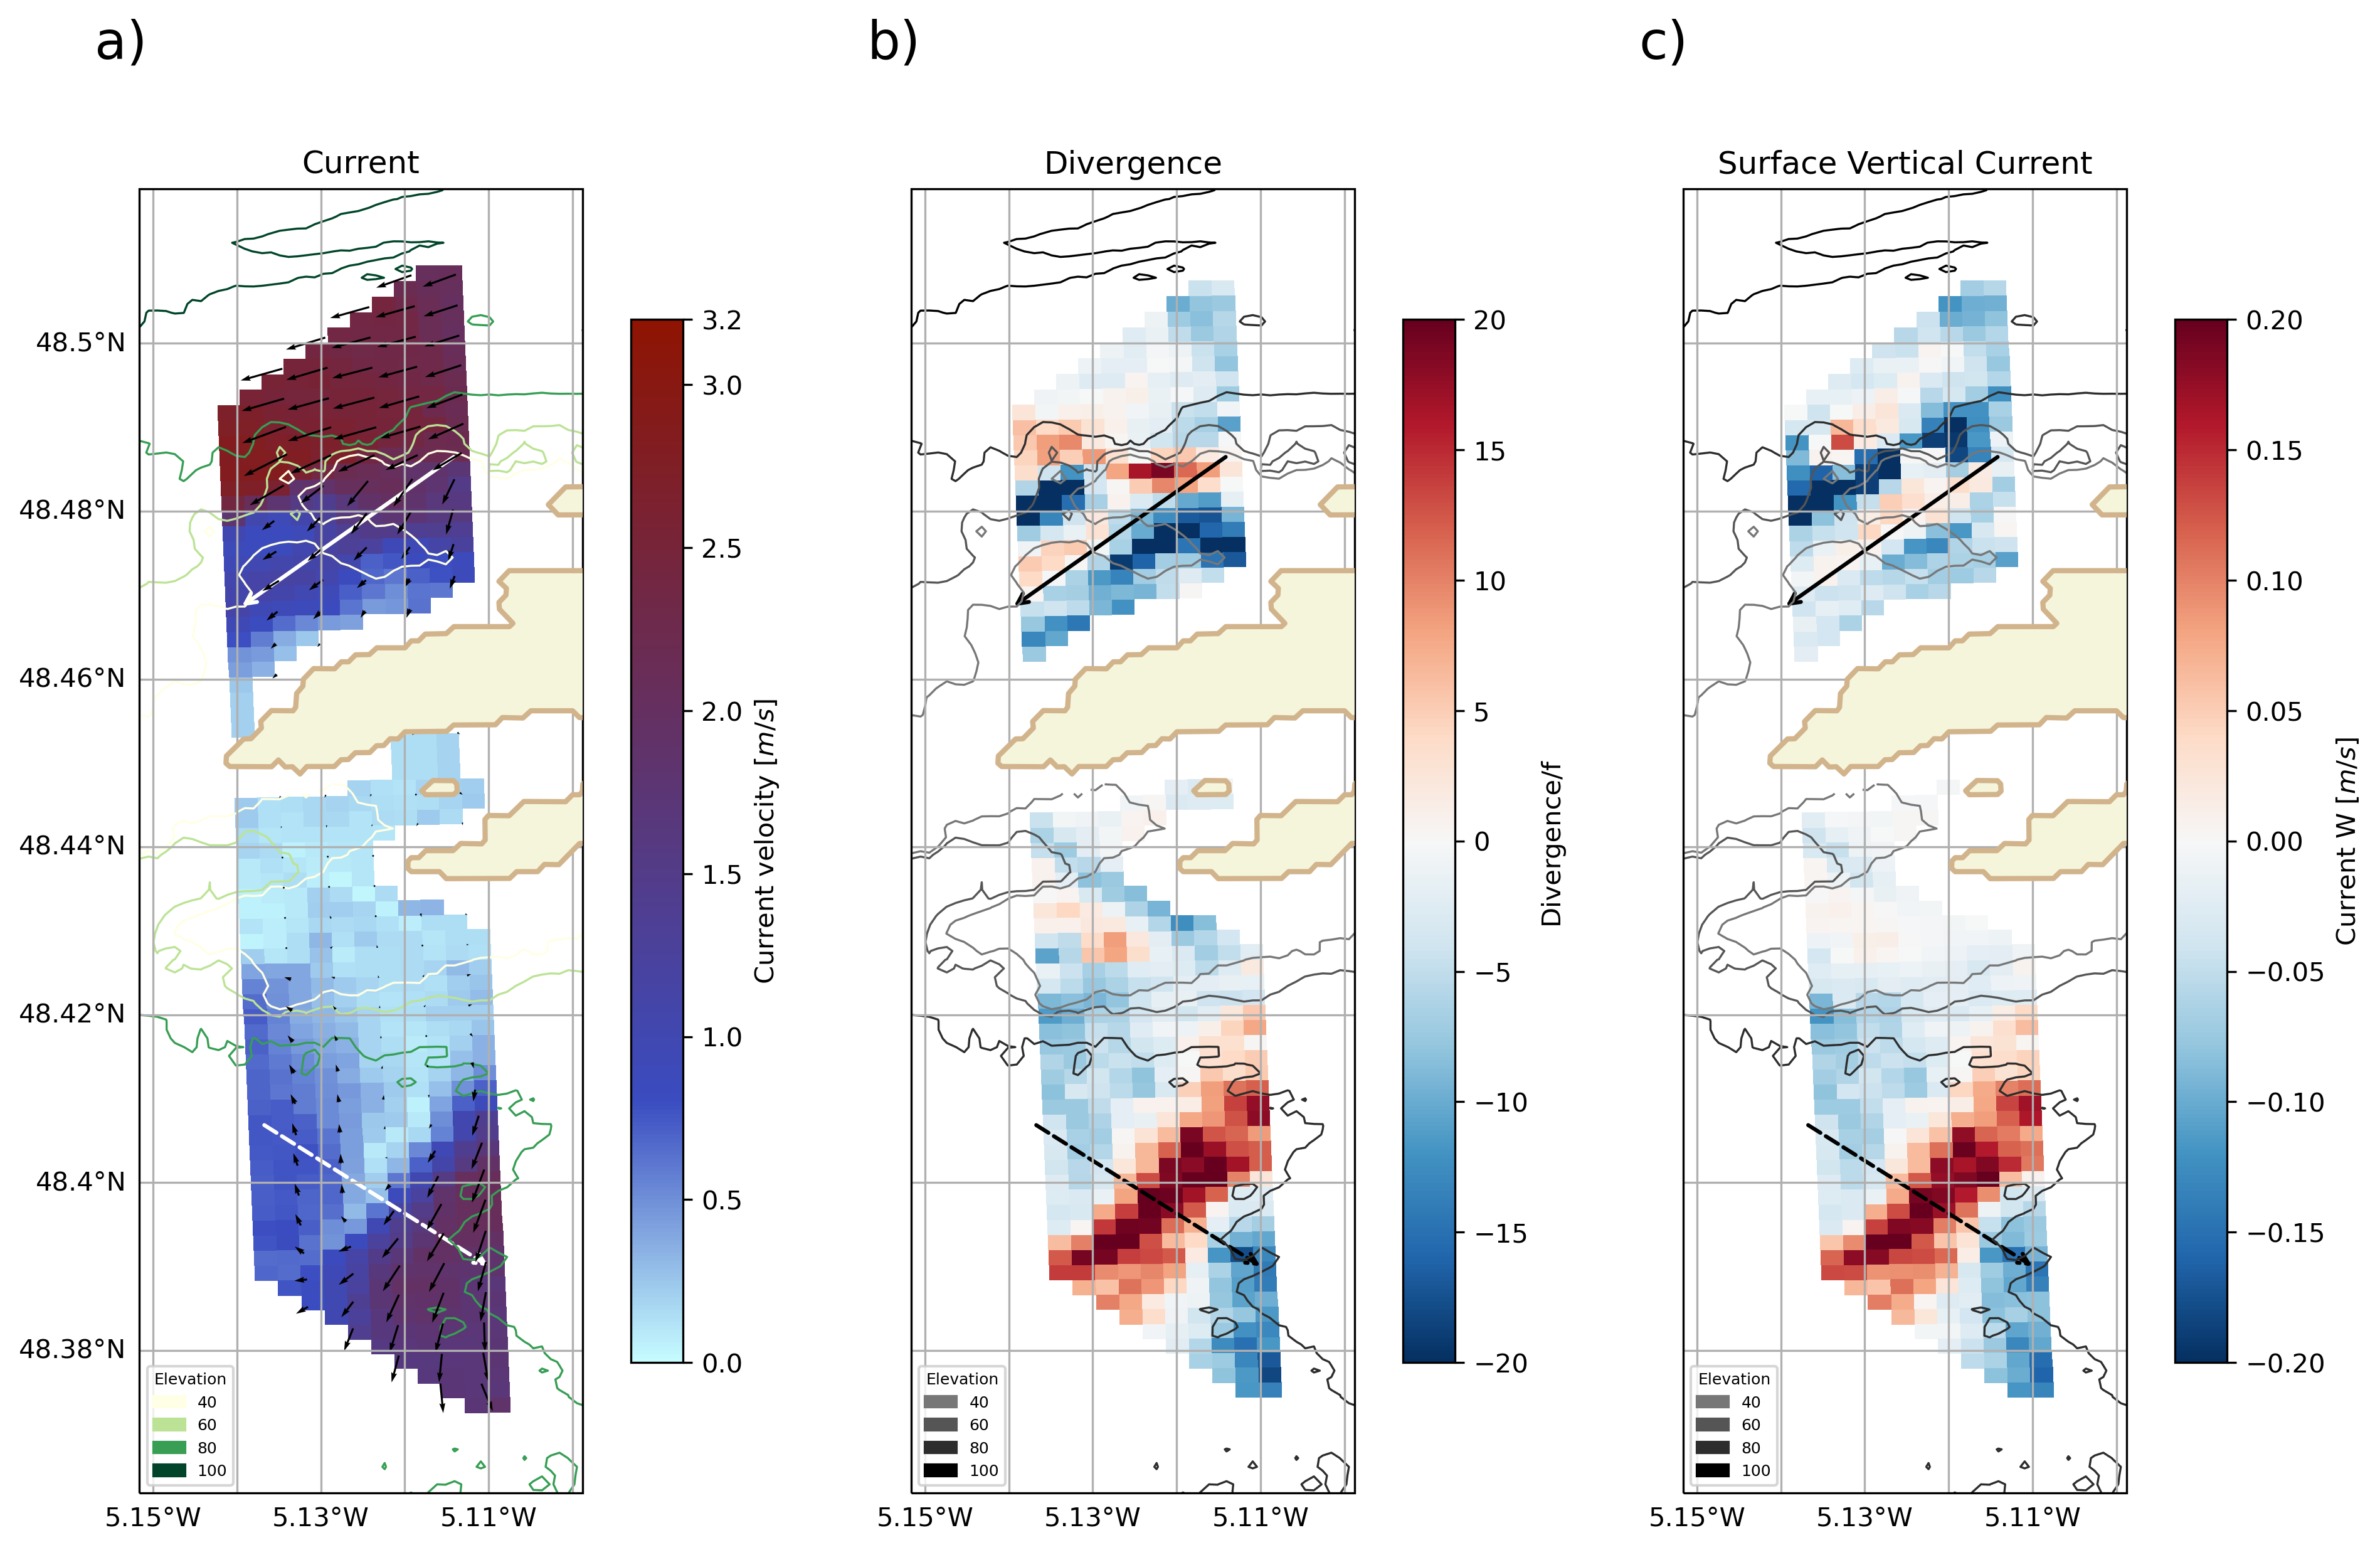

In [29]:
# plot figure 1
axes = plot_all_three_on_one(
    DS=OSCAR,
    bathymetry=bathymetry,
    figsize=(15, 9),
    legend_location="lower left",
    xoffset=-0.01,
    yoffset=-0.01,
)

# find the coordinates of the transects
coordinates_north = ph.extract_transect_range(current_transect_north)
coordinates_south = ph.extract_transect_range(current_transect_south)

# add arrows
ph.add_arrow(axes[0], **coordinates_north, color="white", linewidth=1.5)
for ax in axes[1:]:
    ph.add_arrow(ax, **coordinates_north, color="black", linewidth=1.5)

ph.add_arrow(axes[0], **coordinates_south, color="white", linewidth=1.5, linestyle="--")
for ax in axes[1:]:
    ph.add_arrow(ax, **coordinates_south, color="black", linewidth=1.5, linestyle="--")

ph.print_ranges(OSCAR)

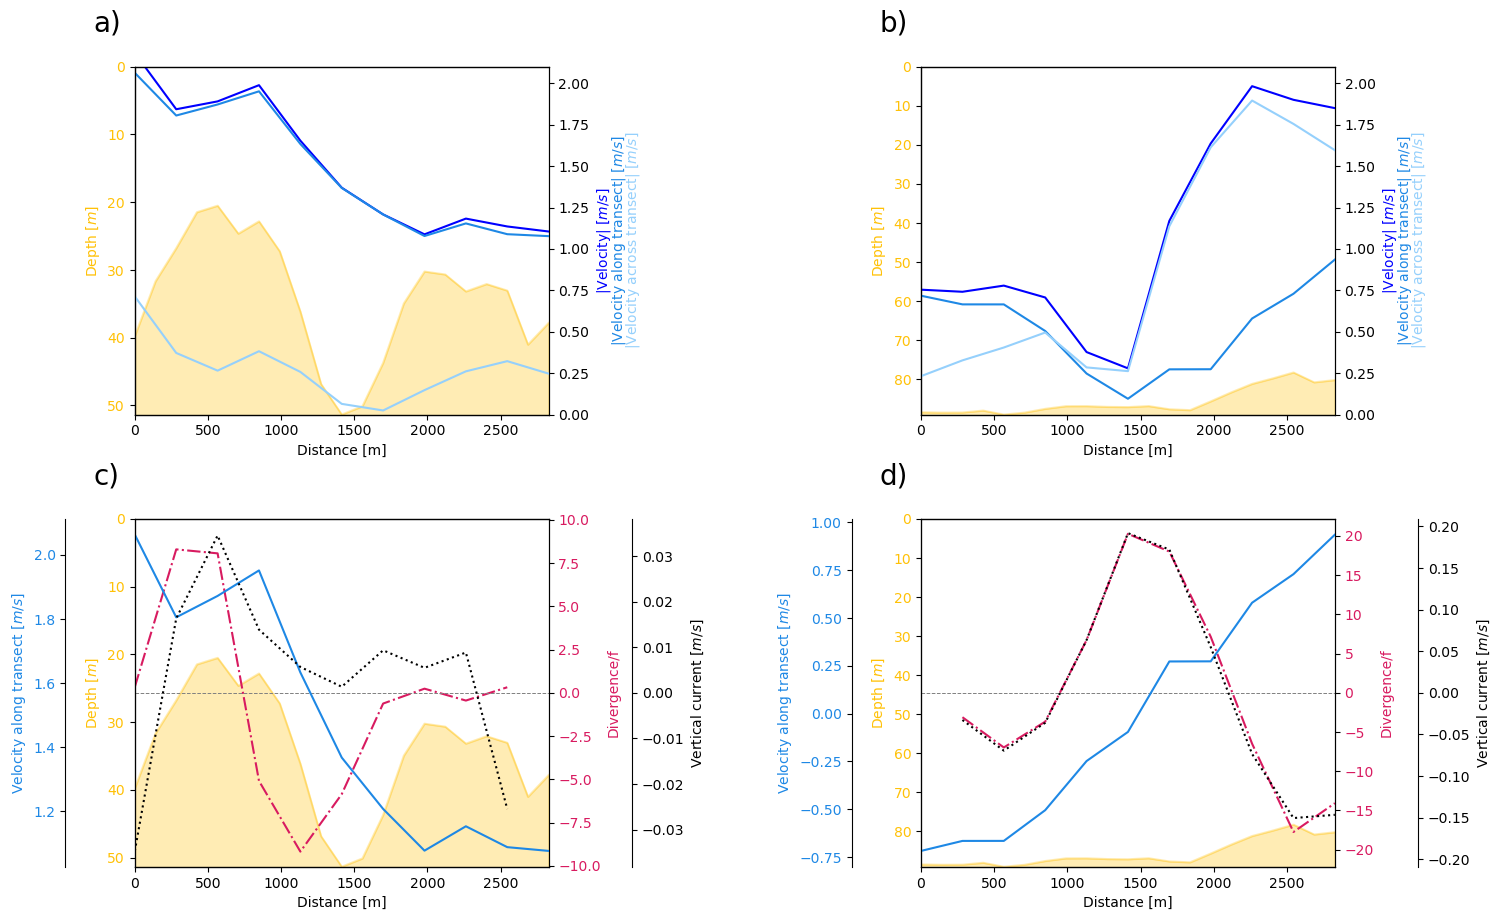

In [30]:
# plot figure 2
current_transects = [current_transect_north, current_transect_south]
elevation_transects = [elevation_transect_north, elevation_transect_south]
plot_transects(current_transects, elevation_transects)

Max velocity: 3.2582273483276367
Divergence range: -21.330617159409158,53.35447522612887
Vertical velocity range: -0.21349647792342916,0.18054755414215257


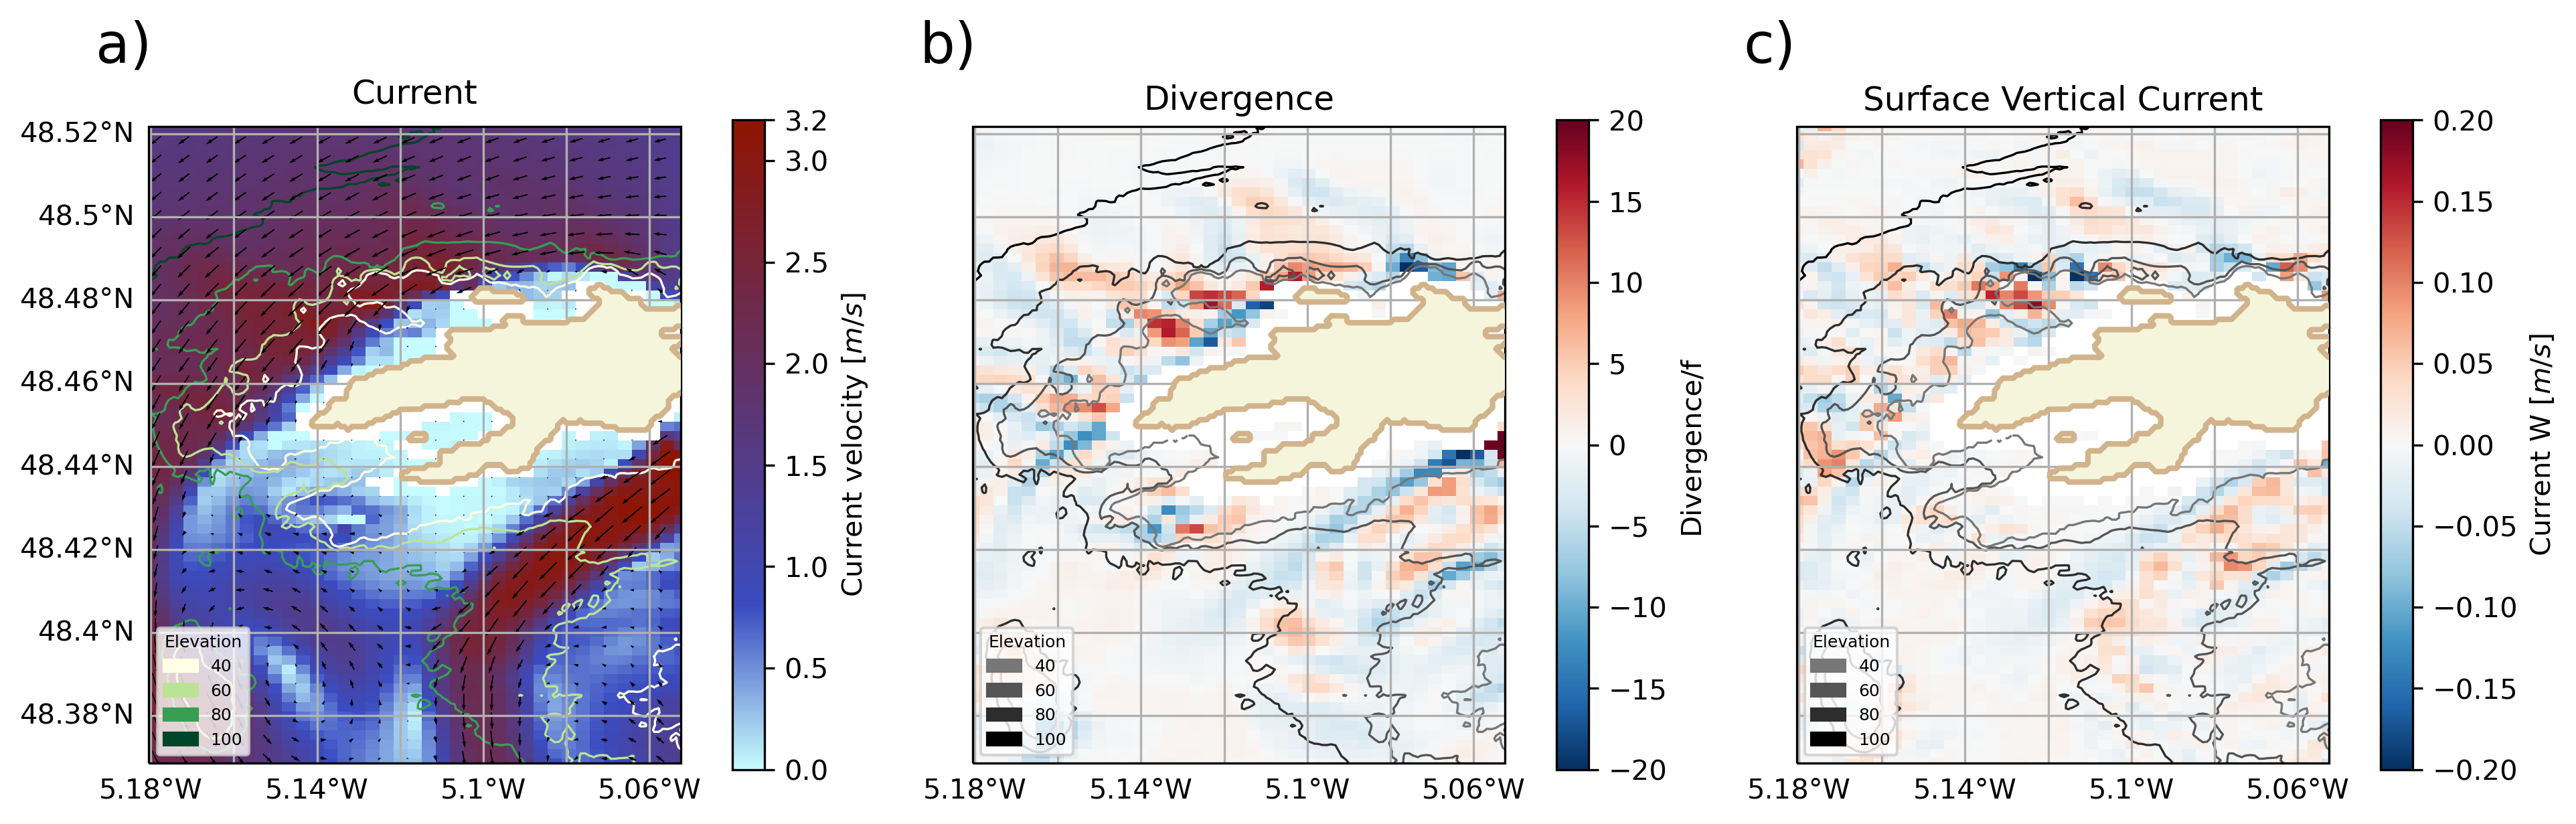

In [34]:
# plot figure 4
_ = plot_all_three_on_one(
    DS=MARS2D,
    bathymetry=bathymetry,
    figsize=(15, 5.25),
    legend_location="lower left",
)

ph.print_ranges(MARS2D)

Max velocity: 2.7907280921936035
Divergence range: -52.27248633056639,12.654146965151115


KeyError: 'CurrentW'

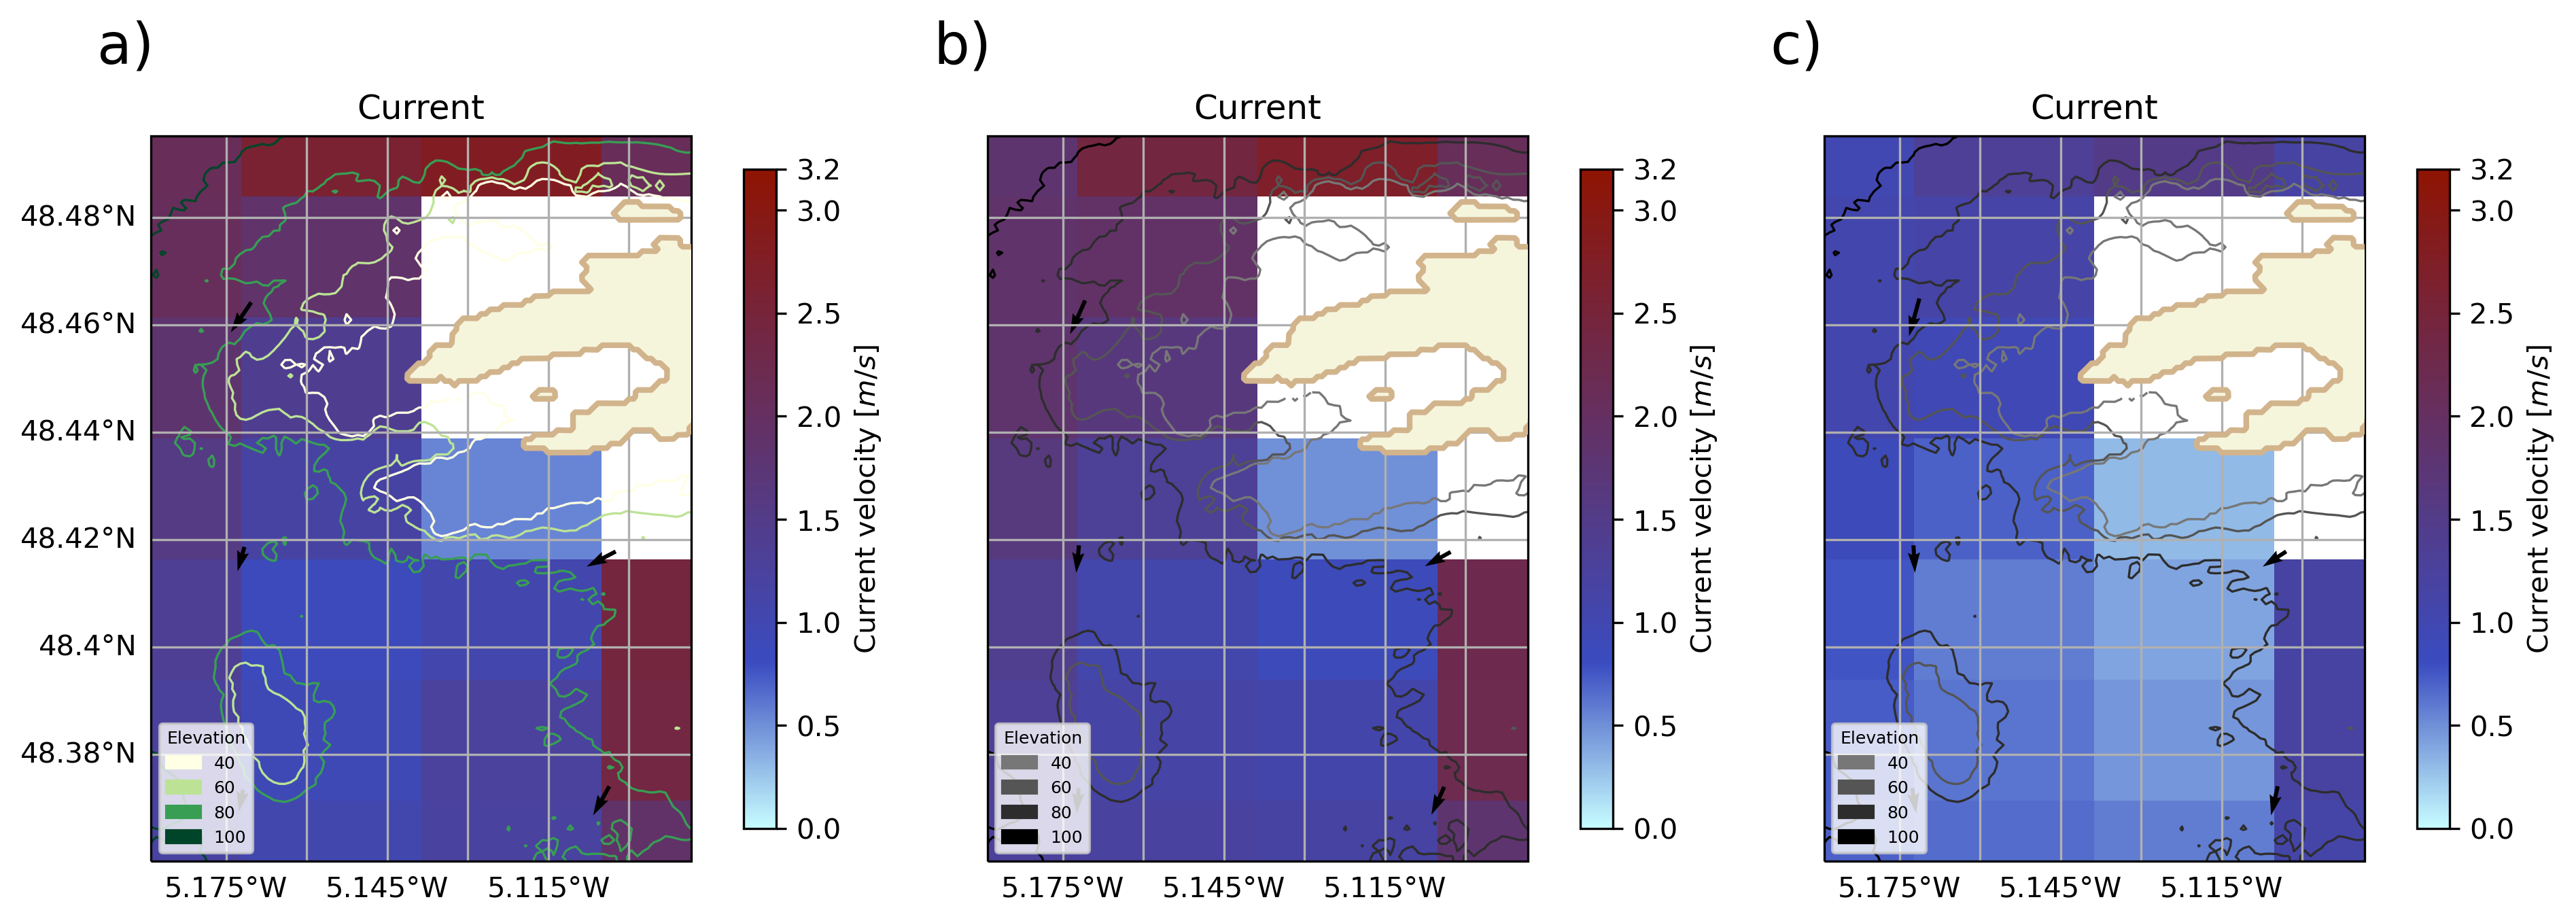

In [38]:
# plot figure 4
_ = plot_MARS3D_levels(
    DS=MARS3D,
    bathymetry=bathymetry,
    figsize=(15, 5.25),
    legend_location="lower left",
)

ph.print_ranges(MARS3D)